# homework_part2.ipynb


Let's check how ConvNeXt architecture looks like and which training technics were used to make it work

This homework assumes than you have already solved the previous homework.

The homework contains three parts:

1. Implementation of some staff for ConvNeXt network definition
2. Implementation of some other staff for effective training
3. Experiments with model averaging, label smoothing and layer norm


# 1. Prerequesites: dataset and data loaders

We will continue to use Tiny-Imagenet dataset. So let's download it in a way, how we did it in the previous homework.

In [ ]:
#!S:bash
# if you are in colab, just add '!' in the start of the following line
! wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
! wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

In [ ]:
#!L
from tiny_img import download_tinyImg200
# data_path = '.'
# download_tinyImg200(data_path)

We will also need some code from the previous homework, that defines training data augmentations and represents validation data as dataset (class `TinyImagenetValDataset` below). Feel free to copy-paste the code from your solution of the previous homework.

In [2]:
#!L
import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [3]:
train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     # YOUR CODE : examine torchvision.transforms package, find transformation for color jittering
     # and add it with proper parameters.
     transforms.ColorJitter()
     # you may add any other transforms here
     ]
)

In [4]:
#!L
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [03:44<00:00,  1.12s/it]


In [5]:
!pip install imageio

pip is disabled in bash. Please use %pip magic.


Exception: Process exited with code 1

One more block from the previous homework that we will need here (fill free to copy-paste it from your previous solution)

In [6]:
from torch.utils.data import Dataset
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        # YOUR CODE
        self.classes = sorted(list(set([item[1] for item in annotations])))

        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            # YOUR CODE
            image = tiny_img_dataset.read_rgb_image(img_name)

            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # take image and its target label from "self.images" and "self.targets",
        # transform the image using self.transform and return the transformed image and its target label

        # YOUR CODE
        image = self.images[index]
        image = self.transform(image)
        target = self.targets[index]

        return image, target

In [7]:
#!L

val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:25<00:00, 392.52it/s]


In [8]:
#!L
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
#!L
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 2. ConvNeXt architecture

In [10]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np

What are the key differences between resnet-50 and ConvNeXt architectures?
- stem redesign: single conv layer with kernel size 4 and stride 4 instead of combination of conv layer and max pooling (+0.1%)
- stage ratio 1:1:3:1 or 1:1:9:1 (+0.6%)
- depthwise separable convolutions (introduced in ResNeXt) with inverted bottlenecks (introduced in MobileNet v2) (+1.1%)
- some micro design changes: fewer activations, fewer normalization layers, GELU and LN usage (+0.9%)
- replacing strided convolutions in blocks on separate downscale convolutions (+0.5%)
- improved training technics (+2.7%)
  - Longer training (90 -> 300 epochs)
  - AdamW optimizer, warm-up, cosine scheduler (we will discuss it in seminar 3).
  - Advanced data augmentation techniques: Mixup, Cutmix, RandAugment, Random Erasing (we will discuss it in seminar 3)
  - Regularization schemes: Stochastic Depth, Label Smoothing
  - LayerScale
  - exponential moving average on network weights

<table>
    <tr>
        <td><h3>Architecture</h3></td>
        <td><h3>Improvements</h3></td>
    </tr>
    <tr>
        <td><img src="https://github.com/PavelPaha/deep_vision_and_graphics/blob/fall24/homework01/convnext_arch.png?raw=1" alt="drawing" width="500"/></td>
        <td><img src="https://github.com/PavelPaha/deep_vision_and_graphics/blob/fall24/homework01/convnext_impr.png?raw=1" alt="drawing" width="500"/></td>
    </tr>
</table>

## 2.1 ConvNeXt block design

Here is how a single block looks like

<img src="https://github.com/PavelPaha/deep_vision_and_graphics/blob/fall24/homework01/convnext_block.png?raw=1" alt="drawing" width="200"/>

### 2.1.1 Depthwise convolutions

Depthwise convolutions is the special case of group convolutions. Here is a good illustration of how group convolution works:

<img src="https://github.com/PavelPaha/deep_vision_and_graphics/blob/fall24/homework01/group_conv.png?raw=1" alt="drawing" width="500"/>

([image credit](https://cvml-expertguide.net/terms/dl/layers/convolution-layer/grouped-convolution/))

Group convolution takes 4d tensor of shape [N,C,H,W] as input, splits it evenly on K groups (K is hyperparameter; K=4 in image above) along the channel dimension, applies vanilla 2d convolution to each group with their own kernels and then concat the output tensors along the channel dimension.

In depthwise convolution number of groups is equal to the number of input channels C. It is usually followed by "pointwise convolution" - convolution with 1x1 kernel, which changes the number of output channels.

<img src="https://github.com/PavelPaha/deep_vision_and_graphics/blob/fall24/homework01/dw_conv.png?raw=1" alt="drawing" width="500"/>

([image credit](https://www.researchgate.net/figure/Depthwise-separable-convolutions_fig1_358585116))

The number of output channels in depthwise convolution by design is greater or equal than number of input channels (why?). For group convolutions the number of output channels could not be less than the number of groups.

Here is how you can implement depthwise convolution 7x7 in pytorch:

In [11]:
n_input_channels = 96
n_output_channels = 192
# TODO: examine nn.Conv2d doc and create depthwise conv layer with 96 input channels, 192 output channels, 7x7 kernel
layer = nn.Conv2d(in_channels=n_input_channels, out_channels=n_output_channels , groups=96, kernel_size=7)

parameters_size = sum([elem.size().numel() for elem in layer.parameters()])
assert parameters_size == (7*7*192 + 192), parameters_size

Note that amount of parameters for kernel is 7x7x192. Vanilla Conv2d would have 7x7x192x96 parameters in kernel under the same settings.

### 2.1.2 LayerNorm and GELU

You are parially familiar with LayerNorm and GELU layers from lecture 2. And we will discuss these layers on lecture 3 and seminar 3.

What is important to know here is that the authors of ConvNeXt replaced ReLU with GELU and BatchNorm with LayerNorm and got some improvements (+0.1%).

In the experiments section below we will check if LayerNorm really helps in our training setup.

But before we start, let's implement simple wrapper over nn.LayerNorm so than it would work with 4d tensors more like batch norm does. BatchNorm2D expects to work with [N,C,H,W] tensors and normalizes the channel dimension. nn.LayerNorm normalizes the last dimension of the input tensor.

So let's permute dimensions in LayerNorm2d forward() method, apply the standard nn.LayerNorm to the new tensor and permute its dimensions back.

In [12]:
class LayerNorm2d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.ln = nn.LayerNorm(dim)

    def forward(self, x):
        # TODO: YOUR CODE
        # 1. permute tensor dimensions so that channel dim became the last
        # 2. apply self.ln
        # 3. permute tensor dimensions back
        x = x.permute((0, 2, 3, 1)).contiguous()
        x = self.ln.forward(x)
        x = x.permute((0, 3, 1, 2)).contiguous()
        return x

In [13]:
x = torch.rand((2, 5, 4, 3))
layer = LayerNorm2d(5)
out = layer(x)
assert out.size() == x.size()
parameters_size = sum([elem.size().numel() for elem in layer.parameters()])
assert parameters_size == 10, parameters_size  # 5 for channel weights and 5 for biases

### 2.1.3 LayerScale

LayerScale is a technique used to force residual branch to work more like residual branch.
<table>
    <tr>
        <td><center><h4>Original residual branch for transformer</h4></center></td>
        <td><center><h4>Residual branch with LayerScale</h4></center></td>
    </tr>
    <tr>
        <td><center><img src="https://github.com/PavelPaha/deep_vision_and_graphics/blob/fall24/homework01/layer_scale-orig_residual.png?raw=1" alt="drawing" height="400"/></center></td>
        <td><center><img src="https://github.com/PavelPaha/deep_vision_and_graphics/blob/fall24/homework01/layer_scale-new_residual.png?raw=1" alt="drawing" height="400"/></center></td>
    </tr>
</table>

LayerScale downscales residual branch output with some (learnable) weights which are very small at the begining (1e-6 in our experiments and in paper) but can become larger during training.

Scaling is applied to each channel independenly. Here is implementation of the layer:

In [14]:
class LayerScale2d(nn.Module):
    def __init__(self, dim, layer_scale_init_value):
        super().__init__()
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim, 1, 1)), requires_grad=True)

    def forward(self, x):
        # YOUR CODE: just scale x on self.gamma
        x = self.gamma * x
        return x

In [15]:
x = torch.rand((2, 5, 4, 3))
layer_scale_init_value = 1e-5
layer = LayerScale2d(5, layer_scale_init_value)
out = layer(x)
assert out.size() == x.size()
assert np.allclose(out.detach().numpy(), x.numpy()*layer_scale_init_value)

### 2.1.4 Stochastic Depth

Stochastic depth was introduced in [paper](https://arxiv.org/pdf/1603.09382.pdf) as a way of overfitting reduction. You can think of it as about dropout on residual branches. Block with residual connection with stochastic depth module looks like `y = x + DropPath(ResidualNet(x))` instead of classic `y = x + ResidualNet(x)`

Let's implement `DropPath` module. Its only parameter is `drop_prob` - probability to zero-out its input. Don't forget to devide the result on `(1-drop_prob)` in order to fix mean value of output in train mode (as it is usually done in `Dropout` layer).

(This layer will be also discussed in seminar dedicated to vision transformers)

In [16]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
        # YOUR CODE: generate random tensor, binarize it, cast to x.dtype, multiply x by the mask, 
        # devide the result on keep_prob
        random_tensor = torch.rand(shape)
        mask = random_tensor > self.drop_prob
        mask = mask.type(x.type())
        output = x * mask / keep_prob
        return output

In [17]:
layer = DropPath(0.5)

x = torch.rand((10,5,4,3))

layer.eval()
out = layer(x)
assert out.size() == x.size()
assert (out == x).all()

layer.train()
out = layer(x)
assert out.size() == x.size()
dropped_samples_mask = torch.isclose(out, torch.zeros([1])).all(dim=1).all(dim=1).all(dim=1)
n_dropped_samples = dropped_samples_mask.to(float).sum()
assert n_dropped_samples > 2 and n_dropped_samples < 8, n_dropped_samples



layer = DropPath(0.1)
out = layer(x)
dropped_samples_mask = torch.isclose(out, torch.zeros([1])).all(dim=1).all(dim=1).all(dim=1)
scaled_samples_mask = torch.isclose(out, x/0.9).all(dim=1).all(dim=1).all(dim=1)
assert torch.logical_or(dropped_samples_mask, scaled_samples_mask).all()                                                    

### 2.1.5 Putting it all together

Once again, image of ConvNeXt block

<img src="https://github.com/PavelPaha/deep_vision_and_graphics/blob/fall24/homework01/convnext_block.png?raw=1" alt="drawing" width="200"/>

The only thing that is not shown on the image is `DropPath` block which should be applied in the end of residual branch just after `LayerScale2d`

We will create `ConvNextBlock` that can operates with `LayerNorm2d` and `BatchNorm2d` depending on parameter `use_bn` and will check what will perform better in our experiments.

In [18]:
#!L

class ConvNextBlock(nn.Module):
    def __init__(self, dim, drop_rate=0., layer_scale_init_value=1e-6, use_bn=False):
        super().__init__()

        # YOUR CODE: define self.depthwise_conv  self.pointwise_conv1 self.pointwise_conv2
        self.depthwise_conv = nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=5, padding=2, groups=dim)  # depthwise conv 5x5, padding 2, dim->dim

        self.norm = LayerNorm2d(dim) if not use_bn else nn.BatchNorm2d(dim)

        self.pointwise_conv1 = nn.Conv2d(in_channels=dim, out_channels=4*dim, kernel_size=1)  # 1x1 conv, dim -> dim*4  YOUR CODE

        self.activation = nn.GELU()

        self.pointwise_conv2 = nn.Conv2d(in_channels=4*dim, out_channels=dim, kernel_size=1)  # 1x1 conv, 4*dim -> dim YOUR CODE

        self.layer_scale = LayerScale2d(dim, layer_scale_init_value) if layer_scale_init_value > 0 else nn.Identity()
        self.drop_path = DropPath(drop_rate) if drop_rate is not None and drop_rate > 0. else nn.Identity()

    def forward(self, x):
        input = x
        # YOUR CODE: sequentially apply to x: depthwise_conv + norm + pointwise_conv1 + activation + pointwise_conv2 + layer_scale
        x = self.depthwise_conv(x)
        x = self.norm(x)
        x = self.pointwise_conv1(x)
        x = self.activation(x)
        x = self.pointwise_conv2(x)
        x = self.layer_scale(x)
        x = input + self.drop_path(x)
        return x


In [19]:
block_w_ln = ConvNextBlock(7, 0.1, 1e-6, use_bn=False)

x = torch.rand([2,7,4,3])
out = block_w_ln(x)

assert out.size() == x.size()
n_dwconv_parameters = sum([elem.size().numel() for elem in block_w_ln.depthwise_conv.parameters()])
assert n_dwconv_parameters == 5*5*7 + 7, n_dwconv_parameters
n_pwconv1_parameters = sum([elem.size().numel() for elem in block_w_ln.pointwise_conv1.parameters()])
assert n_pwconv1_parameters == 7*7*4 + 7*4
n_pwconv2_parameters = sum([elem.size().numel() for elem in block_w_ln.pointwise_conv2.parameters()])
assert n_pwconv2_parameters == 7*7*4 + 7

In [20]:
block_w_bn = ConvNextBlock(7, 0.1, 1e-6, use_bn=True)

x = torch.rand([2,7,4,3])
out = block_w_bn(x)
assert out.size() == x.size()

n_block1_parameters = sum([elem.size().numel() for elem in block_w_ln.parameters()])
n_block2_parameters = sum([elem.size().numel() for elem in block_w_bn.parameters()])
assert n_block1_parameters == n_block2_parameters

## 2.2 ConvNeXt-like arch for Tiny-Imagenet

Since images in tiny-imagenet are 4x downsampled version of imagenet images, we are going to design our own network configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of downsampling layers which downsample feature maps.

Here is our network config:
1. Stem: Conv 2x2 with stride 2, output features = 32 (instead of conv 4x4 with stride 4)
2. Three block levels:
   - [dwise conv5x5, ch=32; conv1x1, ch=128; conv1x1, ch=32] x 2 + downsampling block
   - [dwise conv5x5, ch=64; conv1x1, ch=256; conv1x1, ch=64] x 2 + downsampling block
   - [dwise conv5x5, ch=128; conv1x1, ch=512; conv1x1, ch=128] x 2
3. Global average pooling + FC(200) + softmax

Network config is inspired by the network configs used in the previous homework. It's rather designed to provide fast training and experiments conducting in the current homework and doesn't pretend on being optimal choice w.r.t accuracy/speed trade-off.

In [21]:
#!L
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.mean(x, dim=self.dim)

In [22]:
def create_stem(out_channels, use_bn):
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2, stride=2, padding=0), # YOUR CODE; conv 2x2, stride 2, padding 0
        nn.BatchNorm2d(out_channels) if use_bn else LayerNorm2d(out_channels)
    )

def create_downscale_block(in_channels, out_channels, use_bn):
    return nn.Sequential(
        nn.BatchNorm2d(in_channels) if use_bn else LayerNorm2d(in_channels),
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2, padding=2)  # YOUR CODE: conv 2x2, stride 2, padding 0
    )

In [23]:
def create_convnext_like_network(config=None, use_bn=False, drop_rate=None):
    """
    Creates ConvNeXt like network according to config
    """
    model = nn.Sequential()

    default_config = [[32, 32], [64, 64], [128, 128]]
    config = config or default_config

    stem_out_channels = config[0][0]
    # YOUR CODE: create stem
    model.add_module('stem', create_stem(stem_out_channels, use_bn))

    # progressivily increase drop rate from 0 to 'drop_rate'
    drop_rates = np.linspace(0, drop_rate, sum([len(e) for e in config])) if drop_rate is not None else None

    layer_index = 0
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]
            layer_drop_rate = drop_rates[layer_index] if drop_rates is not None else None

            # YOUR CODE: add ConvNextBlock
            model.add_module(f"{block_index}_{layer_index_in_block}", ConvNextBlock(out_channels, layer_drop_rate, use_bn))
            layer_index += 1

        if block_index != len(config) - 1:
            downscale_in_channels = out_channels
            downscale_out_channels = config[block_index+1][0]
            # YOUR CODE: add downscale block
            model.add_module(f'downscale_{block_index}', create_downscale_block(downscale_in_channels, downscale_out_channels, use_bn))

    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('norm_final', nn.BatchNorm1d(out_channels) if use_bn else nn.LayerNorm(out_channels))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

# 3. Training technics


## 3.1 Label smooting


Label smoothing is a regularization thechnique that slightly changes gt distributions of classes allowing positive class gt probability be less than 1.0. In fact it introduces one hyperparameter `label_smoothing` in cross-entropy and makes positive class gt prob equal to `1.0 - label_smoothing + label_smoothing/n_classes` and negative classes gt prob equal to `label_smooting / n_classes`.

It helps with optimization on datasets with complex intra-class dependencies when it's hard to zero-out all negative classes probabilities. You can imagine a classic imagenet-like situation, when a neural network should distinguish several dozens of dog breeds. It's a hard task for human and in practice we don't need probabilities for all negative classes to be zeroed-out. What we need is any network prediction when the gt class probability is larger than all other class probabilities.  Introducing small positive probability on negative classes helps neural network to work better in these cases.

In [24]:
#!L
def compute_loss(predictions, gt, label_smoothing=0.0):
    return F.cross_entropy(predictions, gt, label_smoothing=label_smoothing).mean()

## 3.2 EMA on network weights

TL;DR Just check the documentation from pytorch about what what weight averaging is and how it can helps you: https://pytorch.org/docs/stable/optim.html#weight-averaging-swa-and-ema

In [25]:
def create_averaged_model(model, decay=0.999):
    # YOUR CODE: create AveragedModel instance with ema multi_avg_fn (dont forget to use 'decay' parameter)
    def ema_avg_fn(averaged_model_parameter, model_parameter, num_averaged):
        return decay * averaged_model_parameter + (1 - decay) * model_parameter
    averaged_model = torch.optim.swa_utils.AveragedModel(model, avg_fn=ema_avg_fn)
    return averaged_model

For correct processing of averaged model we will need to modify `train_model()` and `train_loop()` from the previous homework.

In [26]:
import numpy as np
import time
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)


def train_model(model, optimizer, train_data_generator, ema_model=None, label_smoothing=0.0):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        opt.zero_grad()

        # forward
        # YOUR CODE: move X_batch, y_batch to 'device', compute model outputs on X_batch,
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)

        loss = compute_loss(predictions, y_batch, label_smoothing)

        # backward
        loss.backward()
        optimizer.step()

        if ema_model is not None:
            # YOUR CODE: update parameters of ema model here (see pytorch doc on AveragedModel)
            ema_model.update_parameters(model)

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def get_input_for_bn_recompute(data_generator):
    for i, (x, y) in enumerate(data_generator):
        x = x.to(device)
        yield x
        if i == 100:
            break


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs, ema_model=None, label_smoothing=0.0):
    """
    num_epochs - total amount of full passes over training data
    """
    train_metrics = defaultdict(list)
    val_metrics = defaultdict(list)

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train_model(model, optimizer, train_data_generator, ema_model, label_smoothing)

        if ema_model is not None:
            # YOUR CODE: update batchnorm statistics for ema_model (see pytorch doc on AveragedModel)
            torch.optim.swa_utils.update_bn(get_input_for_bn_recompute(train_data_generator), ema_model)
            # you may need get_input_for_bn_recompute() function here
            val_accuracy_ema_model = eval_model(ema_model, val_data_generator)

        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))
        train_metrics['loss'].append(train_loss)
        val_metrics['accuracy'].append(val_accuracy)

        if ema_model:
            print("  validation accuracy(ema): \t\t\t{:.2f} %".format(val_accuracy_ema_model * 100))
            val_metrics['ema_model_accuracy'].append(val_accuracy_ema_model)

    print('Best model accuracy: ', max(val_metrics['accuracy']))
    if ema_model:
        print('Best ema model accuracy: ', max(val_metrics['ema_model_accuracy']))

    plt.plot(val_metrics['accuracy'], label='model')
    if ema_model:
        plt.plot(val_metrics['ema_model_accuracy'], label='ema_model')
    plt.grid()
    plt.legend(loc='best')
    return train_metrics, val_metrics

# 4. Experiments

All the preparation is done, time to run the training and check the improvements from all the stuff.

## 4.1 EMA on network weights

Our baseline is ConvNeXt architecture without DropPath and LabelSmooting and with BatchNorm instead of LayerNorm.

Let's check how much improvement we can get from network weights averaging.

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:09<00:00, 22.46it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 1 of 30 took 77.783s
  training loss (in-iteration): 	4.141172
  validation accuracy: 			21.42 %
  validation accuracy(ema): 			17.76 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.87it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 2 of 30 took 73.635s
  training loss (in-iteration): 	3.275507
  validation accuracy: 			28.54 %
  validation accuracy(ema): 			29.61 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 24.04it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 3 of 30 took 73.127s
  training loss (in-iteration): 	2.943105
  validation accuracy: 			33.63 %
  validation accuracy(ema): 			35.36 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.96it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 4 of 30 took 73.367s
  training loss (in-iteration): 	2.728050
  validation accuracy: 			36.07 %
  validation accuracy(ema): 			39.14 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.91it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 5 of 30 took 73.606s
  training loss (in-iteration): 	2.561075
  validation accuracy: 			38.20 %
  validation accuracy(ema): 			41.15 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.90it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 6 of 30 took 73.552s
  training loss (in-iteration): 	2.423662
  validation accuracy: 			39.60 %
  validation accuracy(ema): 			42.76 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.99it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 7 of 30 took 73.272s
  training loss (in-iteration): 	2.311802
  validation accuracy: 			40.57 %
  validation accuracy(ema): 			44.05 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.98it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 8 of 30 took 73.347s
  training loss (in-iteration): 	2.205333
  validation accuracy: 			41.38 %
  validation accuracy(ema): 			45.00 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.98it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 9 of 30 took 73.347s
  training loss (in-iteration): 	2.110837
  validation accuracy: 			42.33 %
  validation accuracy(ema): 			45.63 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.95it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 10 of 30 took 73.480s
  training loss (in-iteration): 	2.029644
  validation accuracy: 			43.09 %
  validation accuracy(ema): 			46.51 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.89it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 11 of 30 took 73.687s
  training loss (in-iteration): 	1.950605
  validation accuracy: 			42.95 %
  validation accuracy(ema): 			47.45 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.92it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 12 of 30 took 73.524s
  training loss (in-iteration): 	1.883580
  validation accuracy: 			43.64 %
  validation accuracy(ema): 			47.77 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.89it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 13 of 30 took 73.635s
  training loss (in-iteration): 	1.818189
  validation accuracy: 			43.97 %
  validation accuracy(ema): 			48.26 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.94it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 14 of 30 took 73.490s
  training loss (in-iteration): 	1.757944
  validation accuracy: 			44.67 %
  validation accuracy(ema): 			48.49 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 24.03it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 15 of 30 took 73.217s
  training loss (in-iteration): 	1.700987
  validation accuracy: 			44.72 %
  validation accuracy(ema): 			48.67 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 24.01it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 16 of 30 took 73.292s
  training loss (in-iteration): 	1.647585
  validation accuracy: 			44.44 %
  validation accuracy(ema): 			48.42 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.98it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 17 of 30 took 73.405s
  training loss (in-iteration): 	1.599494
  validation accuracy: 			44.69 %
  validation accuracy(ema): 			48.37 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.96it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 18 of 30 took 73.376s
  training loss (in-iteration): 	1.548635
  validation accuracy: 			45.10 %
  validation accuracy(ema): 			48.44 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.92it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 19 of 30 took 73.517s
  training loss (in-iteration): 	1.508139
  validation accuracy: 			44.90 %
  validation accuracy(ema): 			48.40 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.97it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 20 of 30 took 73.398s
  training loss (in-iteration): 	1.467116
  validation accuracy: 			45.02 %
  validation accuracy(ema): 			48.29 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.96it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 21 of 30 took 73.464s
  training loss (in-iteration): 	1.428924
  validation accuracy: 			45.24 %
  validation accuracy(ema): 			47.98 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.89it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 22 of 30 took 73.691s
  training loss (in-iteration): 	1.392772
  validation accuracy: 			44.81 %
  validation accuracy(ema): 			48.09 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.83it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 23 of 30 took 73.786s
  training loss (in-iteration): 	1.356418
  validation accuracy: 			45.00 %
  validation accuracy(ema): 			48.08 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.95it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 24 of 30 took 73.494s
  training loss (in-iteration): 	1.323188
  validation accuracy: 			45.23 %
  validation accuracy(ema): 			47.92 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.92it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 25 of 30 took 73.543s
  training loss (in-iteration): 	1.289062
  validation accuracy: 			44.44 %
  validation accuracy(ema): 			47.95 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.97it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 26 of 30 took 73.385s
  training loss (in-iteration): 	1.257223
  validation accuracy: 			45.16 %
  validation accuracy(ema): 			47.82 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.96it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 27 of 30 took 73.363s
  training loss (in-iteration): 	1.228784
  validation accuracy: 			45.05 %
  validation accuracy(ema): 			47.73 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.92it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 28 of 30 took 73.564s
  training loss (in-iteration): 	1.207053
  validation accuracy: 			44.15 %
  validation accuracy(ema): 			47.69 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 23.97it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 29 of 30 took 73.375s
  training loss (in-iteration): 	1.175936
  validation accuracy: 			44.55 %
  validation accuracy(ema): 			47.61 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:05<00:00, 24.01it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 30 of 30 took 73.333s
  training loss (in-iteration): 	1.150203
  validation accuracy: 			44.27 %
  validation accuracy(ema): 			47.40 %
Best model accuracy:  0.4524283439490446
Best ema model accuracy:  0.4866640127388535


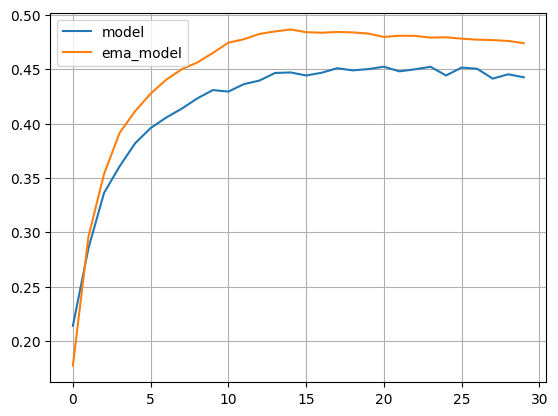

In [27]:
model = create_convnext_like_network(use_bn=True)
model = model.to(device)
ema_model = create_averaged_model(model)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

train_metrics_ema_bn, val_metrics_ema_bn = train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30, ema_model=ema_model)

Normally baseline should give you >42% accuracy here and ema model should give you extra >2%. If it does not, check data augmentation and all the code.

## 4.2 Stochastic depth

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 22.99it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 1 of 30 took 76.220s
  training loss (in-iteration): 	4.274400
  validation accuracy: 			20.59 %
  validation accuracy(ema): 			15.62 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.02it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 2 of 30 took 76.140s
  training loss (in-iteration): 	3.423272
  validation accuracy: 			27.47 %
  validation accuracy(ema): 			28.20 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.00it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 3 of 30 took 76.210s
  training loss (in-iteration): 	3.083513
  validation accuracy: 			31.78 %
  validation accuracy(ema): 			34.19 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.00it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 4 of 30 took 76.221s
  training loss (in-iteration): 	2.863995
  validation accuracy: 			35.08 %
  validation accuracy(ema): 			37.85 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.98it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 5 of 30 took 76.358s
  training loss (in-iteration): 	2.702207
  validation accuracy: 			38.21 %
  validation accuracy(ema): 			40.74 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.97it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 6 of 30 took 76.312s
  training loss (in-iteration): 	2.578820
  validation accuracy: 			39.41 %
  validation accuracy(ema): 			42.34 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 22.99it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 7 of 30 took 76.214s
  training loss (in-iteration): 	2.471903
  validation accuracy: 			40.23 %
  validation accuracy(ema): 			43.87 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.00it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 8 of 30 took 76.209s
  training loss (in-iteration): 	2.379458
  validation accuracy: 			41.89 %
  validation accuracy(ema): 			45.05 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.06it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 9 of 30 took 76.025s
  training loss (in-iteration): 	2.299386
  validation accuracy: 			42.53 %
  validation accuracy(ema): 			45.92 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.95it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 10 of 30 took 76.376s
  training loss (in-iteration): 	2.230325
  validation accuracy: 			43.56 %
  validation accuracy(ema): 			46.89 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.05it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 11 of 30 took 76.065s
  training loss (in-iteration): 	2.160359
  validation accuracy: 			43.35 %
  validation accuracy(ema): 			47.22 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.97it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 12 of 30 took 76.234s
  training loss (in-iteration): 	2.103781
  validation accuracy: 			44.24 %
  validation accuracy(ema): 			47.91 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.93it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 13 of 30 took 76.443s
  training loss (in-iteration): 	2.043334
  validation accuracy: 			45.27 %
  validation accuracy(ema): 			47.97 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 22.99it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 14 of 30 took 76.248s
  training loss (in-iteration): 	1.998306
  validation accuracy: 			45.41 %
  validation accuracy(ema): 			48.56 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.06it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 15 of 30 took 76.144s
  training loss (in-iteration): 	1.951164
  validation accuracy: 			45.17 %
  validation accuracy(ema): 			48.84 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.03it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 16 of 30 took 76.180s
  training loss (in-iteration): 	1.905563
  validation accuracy: 			45.12 %
  validation accuracy(ema): 			48.81 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.93it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 17 of 30 took 76.445s
  training loss (in-iteration): 	1.861745
  validation accuracy: 			45.07 %
  validation accuracy(ema): 			49.09 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.00it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 18 of 30 took 76.252s
  training loss (in-iteration): 	1.826623
  validation accuracy: 			45.55 %
  validation accuracy(ema): 			49.04 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.01it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 19 of 30 took 76.192s
  training loss (in-iteration): 	1.789675
  validation accuracy: 			46.01 %
  validation accuracy(ema): 			49.24 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.03it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 20 of 30 took 76.136s
  training loss (in-iteration): 	1.756043
  validation accuracy: 			46.17 %
  validation accuracy(ema): 			49.50 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.04it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 21 of 30 took 76.108s
  training loss (in-iteration): 	1.723402
  validation accuracy: 			46.72 %
  validation accuracy(ema): 			49.49 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.01it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 22 of 30 took 76.187s
  training loss (in-iteration): 	1.690632
  validation accuracy: 			47.17 %
  validation accuracy(ema): 			49.75 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.03it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 23 of 30 took 76.136s
  training loss (in-iteration): 	1.661228
  validation accuracy: 			45.89 %
  validation accuracy(ema): 			49.81 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.07it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 24 of 30 took 75.989s
  training loss (in-iteration): 	1.631701
  validation accuracy: 			46.56 %
  validation accuracy(ema): 			49.31 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.99it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 25 of 30 took 76.236s
  training loss (in-iteration): 	1.603620
  validation accuracy: 			46.03 %
  validation accuracy(ema): 			49.13 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.04it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 26 of 30 took 76.093s
  training loss (in-iteration): 	1.581847
  validation accuracy: 			46.19 %
  validation accuracy(ema): 			49.49 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:07<00:00, 23.04it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 27 of 30 took 76.107s
  training loss (in-iteration): 	1.561598
  validation accuracy: 			46.94 %
  validation accuracy(ema): 			49.67 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.98it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 28 of 30 took 76.307s
  training loss (in-iteration): 	1.529861
  validation accuracy: 			46.32 %
  validation accuracy(ema): 			49.56 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.93it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 29 of 30 took 76.442s
  training loss (in-iteration): 	1.504697
  validation accuracy: 			46.70 %
  validation accuracy(ema): 			49.35 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.90it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 30 of 30 took 76.534s
  training loss (in-iteration): 	1.483732
  validation accuracy: 			46.88 %
  validation accuracy(ema): 			49.16 %
Best model accuracy:  0.47173566878980894
Best ema model accuracy:  0.498109076433121


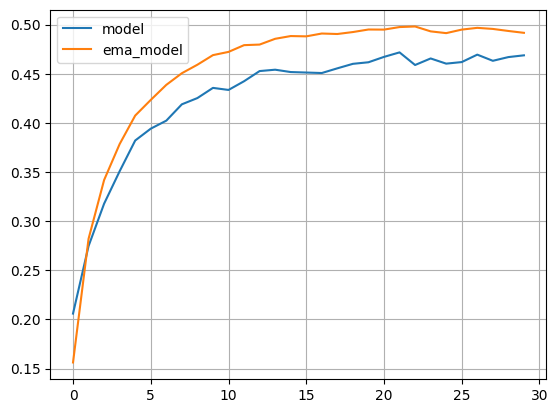

In [28]:
model = create_convnext_like_network(use_bn=True, drop_rate=0.1)
model = model.to(device)
ema_model = create_averaged_model(model)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_metrics_droppath, val_metrics_droppath = train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30, ema_model=ema_model)

If everything was implemented correctly, stochastic depth should give you +1-2% accuracy here comparing to the previous experiment (for single model and for averaged version of this model)

## 4.3 LabelSmooting

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:09<00:00, 22.57it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 1 of 30 took 77.605s
  training loss (in-iteration): 	4.468938
  validation accuracy: 			19.87 %
  validation accuracy(ema): 			16.22 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.76it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 2 of 30 took 76.986s
  training loss (in-iteration): 	3.786725
  validation accuracy: 			28.68 %
  validation accuracy(ema): 			28.75 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.87it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 3 of 30 took 76.658s
  training loss (in-iteration): 	3.516718
  validation accuracy: 			32.64 %
  validation accuracy(ema): 			34.53 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.82it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 4 of 30 took 76.836s
  training loss (in-iteration): 	3.344524
  validation accuracy: 			35.08 %
  validation accuracy(ema): 			38.08 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.79it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 5 of 30 took 76.887s
  training loss (in-iteration): 	3.217963
  validation accuracy: 			38.11 %
  validation accuracy(ema): 			40.60 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.84it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 6 of 30 took 76.725s
  training loss (in-iteration): 	3.117015
  validation accuracy: 			38.90 %
  validation accuracy(ema): 			42.53 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.81it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 7 of 30 took 76.893s
  training loss (in-iteration): 	3.036131
  validation accuracy: 			40.19 %
  validation accuracy(ema): 			44.12 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.77it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 8 of 30 took 76.997s
  training loss (in-iteration): 	2.963370
  validation accuracy: 			41.88 %
  validation accuracy(ema): 			45.10 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.79it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 9 of 30 took 76.940s
  training loss (in-iteration): 	2.903283
  validation accuracy: 			42.29 %
  validation accuracy(ema): 			45.86 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.74it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 10 of 30 took 77.099s
  training loss (in-iteration): 	2.848787
  validation accuracy: 			43.14 %
  validation accuracy(ema): 			46.55 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.66it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 11 of 30 took 77.322s
  training loss (in-iteration): 	2.798393
  validation accuracy: 			43.03 %
  validation accuracy(ema): 			47.25 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.76it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 12 of 30 took 77.091s
  training loss (in-iteration): 	2.751145
  validation accuracy: 			43.81 %
  validation accuracy(ema): 			47.72 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.71it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 13 of 30 took 77.163s
  training loss (in-iteration): 	2.708362
  validation accuracy: 			45.11 %
  validation accuracy(ema): 			47.85 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.69it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 14 of 30 took 77.228s
  training loss (in-iteration): 	2.672567
  validation accuracy: 			44.96 %
  validation accuracy(ema): 			48.15 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.76it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 15 of 30 took 76.998s
  training loss (in-iteration): 	2.636739
  validation accuracy: 			45.77 %
  validation accuracy(ema): 			48.48 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.76it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 16 of 30 took 77.064s
  training loss (in-iteration): 	2.604226
  validation accuracy: 			45.48 %
  validation accuracy(ema): 			48.63 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.79it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 17 of 30 took 76.887s
  training loss (in-iteration): 	2.573845
  validation accuracy: 			45.84 %
  validation accuracy(ema): 			48.91 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.79it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 18 of 30 took 76.959s
  training loss (in-iteration): 	2.542154
  validation accuracy: 			45.95 %
  validation accuracy(ema): 			48.99 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.78it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 19 of 30 took 76.974s
  training loss (in-iteration): 	2.511886
  validation accuracy: 			45.93 %
  validation accuracy(ema): 			49.09 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.80it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 20 of 30 took 76.789s
  training loss (in-iteration): 	2.492501
  validation accuracy: 			46.20 %
  validation accuracy(ema): 			49.46 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.80it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 21 of 30 took 76.870s
  training loss (in-iteration): 	2.464719
  validation accuracy: 			46.54 %
  validation accuracy(ema): 			49.59 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.80it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 22 of 30 took 76.839s
  training loss (in-iteration): 	2.444877
  validation accuracy: 			46.32 %
  validation accuracy(ema): 			49.47 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.71it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 23 of 30 took 77.185s
  training loss (in-iteration): 	2.424185
  validation accuracy: 			46.26 %
  validation accuracy(ema): 			49.77 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.76it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 24 of 30 took 77.036s
  training loss (in-iteration): 	2.399274
  validation accuracy: 			46.99 %
  validation accuracy(ema): 			49.54 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.73it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 25 of 30 took 77.106s
  training loss (in-iteration): 	2.377707
  validation accuracy: 			47.32 %
  validation accuracy(ema): 			49.82 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.68it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 26 of 30 took 77.299s
  training loss (in-iteration): 	2.359905
  validation accuracy: 			46.98 %
  validation accuracy(ema): 			49.94 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.68it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 27 of 30 took 77.298s
  training loss (in-iteration): 	2.341646
  validation accuracy: 			46.52 %
  validation accuracy(ema): 			49.95 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.73it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 28 of 30 took 77.140s
  training loss (in-iteration): 	2.329840
  validation accuracy: 			46.72 %
  validation accuracy(ema): 			49.56 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.71it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 29 of 30 took 77.116s
  training loss (in-iteration): 	2.307035
  validation accuracy: 			46.17 %
  validation accuracy(ema): 			49.65 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:08<00:00, 22.73it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 30 of 30 took 77.129s
  training loss (in-iteration): 	2.295297
  validation accuracy: 			47.04 %
  validation accuracy(ema): 			49.49 %
Best model accuracy:  0.4732285031847134
Best ema model accuracy:  0.49950238853503187


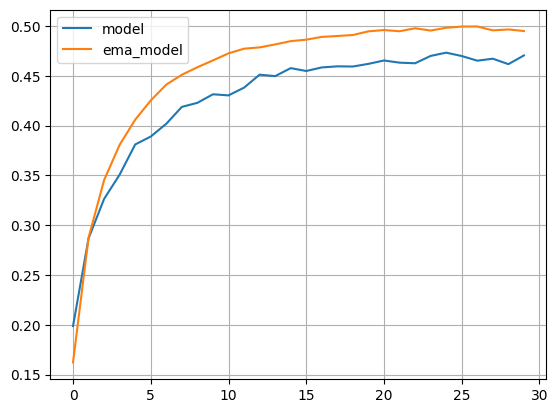

In [ ]:
model = create_convnext_like_network(use_bn=True, drop_rate=0.1)
model = model.to(device)
ema_model = create_averaged_model(model)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_metrics_ls, val_metrics_ls = train_loop(
    model, opt, train_batch_gen, val_batch_gen, num_epochs=30, ema_model=ema_model, label_smoothing=0.1)

Label smoothing should slightly improve quality on ~0.1-0.5%. It should be easier to see on plots:

(0.35, 0.55)

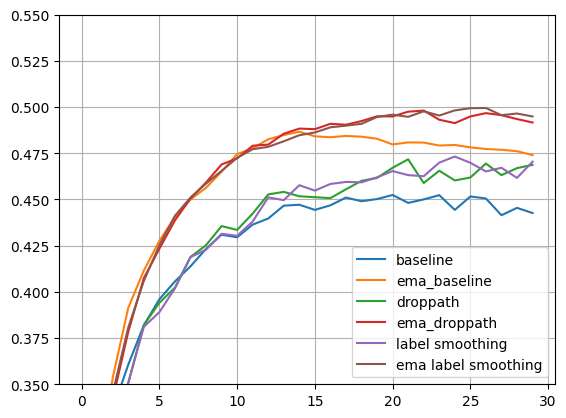

In [ ]:
plt.plot(val_metrics_ema_bn['accuracy'], label='baseline')
plt.plot(val_metrics_ema_bn['ema_model_accuracy'], label='ema_baseline')
plt.plot(val_metrics_droppath['accuracy'], label='droppath')
plt.plot(val_metrics_droppath['ema_model_accuracy'], label='ema_droppath')
plt.plot(val_metrics_ls['accuracy'], label='label smoothing')
plt.plot(val_metrics_ls['ema_model_accuracy'], label='ema label smoothing')
plt.grid()
plt.legend(loc='best')
plt.ylim([0.35, 0.55])

## 4.4 LayerNorm vs BatchNorm

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:09<00:00, 22.56it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 1 of 30 took 74.777s
  training loss (in-iteration): 	4.693397
  validation accuracy: 			14.04 %
  validation accuracy(ema): 			3.78 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.25it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 2 of 30 took 75.789s
  training loss (in-iteration): 	3.742033
  validation accuracy: 			23.15 %
  validation accuracy(ema): 			17.80 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.19it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 3 of 30 took 76.015s
  training loss (in-iteration): 	3.316001
  validation accuracy: 			28.07 %
  validation accuracy(ema): 			28.33 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.15it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 4 of 30 took 76.103s
  training loss (in-iteration): 	3.052696
  validation accuracy: 			31.31 %
  validation accuracy(ema): 			33.72 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.10it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 5 of 30 took 76.332s
  training loss (in-iteration): 	2.858004
  validation accuracy: 			34.88 %
  validation accuracy(ema): 			37.03 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.12it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 6 of 30 took 76.211s
  training loss (in-iteration): 	2.706683
  validation accuracy: 			36.33 %
  validation accuracy(ema): 			39.58 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.12it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 7 of 30 took 76.255s
  training loss (in-iteration): 	2.587863
  validation accuracy: 			39.29 %
  validation accuracy(ema): 			40.96 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.12it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 8 of 30 took 76.178s
  training loss (in-iteration): 	2.475592
  validation accuracy: 			39.20 %
  validation accuracy(ema): 			42.36 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.07it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 9 of 30 took 76.427s
  training loss (in-iteration): 	2.385754
  validation accuracy: 			40.46 %
  validation accuracy(ema): 			43.82 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.11it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 10 of 30 took 76.305s
  training loss (in-iteration): 	2.303202
  validation accuracy: 			40.71 %
  validation accuracy(ema): 			44.82 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.11it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 11 of 30 took 76.291s
  training loss (in-iteration): 	2.223495
  validation accuracy: 			42.42 %
  validation accuracy(ema): 			45.46 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.04it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 12 of 30 took 76.507s
  training loss (in-iteration): 	2.152843
  validation accuracy: 			41.76 %
  validation accuracy(ema): 			46.11 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.10it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 13 of 30 took 76.297s
  training loss (in-iteration): 	2.095839
  validation accuracy: 			43.54 %
  validation accuracy(ema): 			46.59 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.11it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 14 of 30 took 76.249s
  training loss (in-iteration): 	2.041082
  validation accuracy: 			43.25 %
  validation accuracy(ema): 			46.56 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.09it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 15 of 30 took 76.350s
  training loss (in-iteration): 	1.981638
  validation accuracy: 			44.00 %
  validation accuracy(ema): 			47.08 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.08it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 16 of 30 took 76.395s
  training loss (in-iteration): 	1.932115
  validation accuracy: 			44.44 %
  validation accuracy(ema): 			47.20 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.13it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 17 of 30 took 76.190s
  training loss (in-iteration): 	1.883336
  validation accuracy: 			44.65 %
  validation accuracy(ema): 			47.40 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.14it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 18 of 30 took 76.192s
  training loss (in-iteration): 	1.838559
  validation accuracy: 			44.34 %
  validation accuracy(ema): 			47.31 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.15it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 19 of 30 took 76.096s
  training loss (in-iteration): 	1.798860
  validation accuracy: 			44.98 %
  validation accuracy(ema): 			47.56 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.14it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 20 of 30 took 76.131s
  training loss (in-iteration): 	1.756278
  validation accuracy: 			44.53 %
  validation accuracy(ema): 			47.75 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.10it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 21 of 30 took 76.316s
  training loss (in-iteration): 	1.716117
  validation accuracy: 			44.53 %
  validation accuracy(ema): 			47.78 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.09it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 22 of 30 took 76.355s
  training loss (in-iteration): 	1.684819
  validation accuracy: 			45.38 %
  validation accuracy(ema): 			47.31 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.09it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 23 of 30 took 76.336s
  training loss (in-iteration): 	1.646280
  validation accuracy: 			44.82 %
  validation accuracy(ema): 			47.51 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.07it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 24 of 30 took 76.377s
  training loss (in-iteration): 	1.617816
  validation accuracy: 			43.33 %
  validation accuracy(ema): 			47.63 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.06it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 25 of 30 took 76.415s
  training loss (in-iteration): 	1.588556
  validation accuracy: 			44.17 %
  validation accuracy(ema): 			47.75 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.13it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 26 of 30 took 76.166s
  training loss (in-iteration): 	1.562768
  validation accuracy: 			44.81 %
  validation accuracy(ema): 			47.51 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.15it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 27 of 30 took 76.104s
  training loss (in-iteration): 	1.527882
  validation accuracy: 			44.71 %
  validation accuracy(ema): 			48.14 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.18it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 28 of 30 took 76.049s
  training loss (in-iteration): 	1.501741
  validation accuracy: 			45.24 %
  validation accuracy(ema): 			48.22 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.14it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 29 of 30 took 76.143s
  training loss (in-iteration): 	1.479307
  validation accuracy: 			45.49 %
  validation accuracy(ema): 			48.15 %


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:10<00:00, 22.19it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

Epoch 30 of 30 took 75.975s
  training loss (in-iteration): 	1.451177
  validation accuracy: 			44.59 %
  validation accuracy(ema): 			47.85 %
Best model accuracy:  0.45491640127388533
Best ema model accuracy:  0.48218550955414013


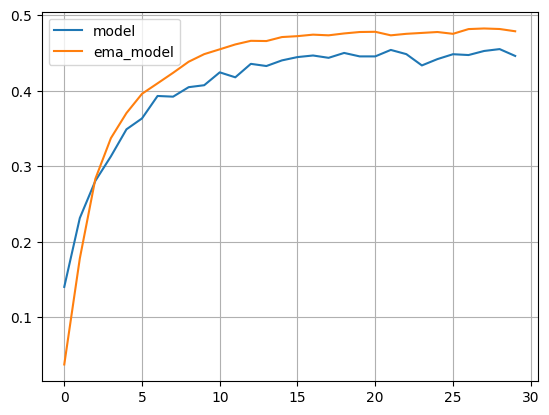

In [31]:
model = create_convnext_like_network(use_bn=False, drop_rate=0.1)
model = model.to(device)
ema_model = create_averaged_model(model)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_metrics_ln, val_metrics_ln = train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30, ema_model=ema_model)

In [ ]:
plt.plot(val_metrics_ema_bn['accuracy'], label='baseline')
plt.plot(val_metrics_ema_bn['ema_model_accuracy'], label='ema_baseline')
plt.plot(val_metrics_droppath['accuracy'], label='droppath')
plt.plot(val_metrics_droppath['ema_model_accuracy'], label='ema_droppath')
plt.plot(val_metrics_ls['accuracy'], label='label smoothing')
plt.plot(val_metrics_ls['ema_model_accuracy'], label='ema label smoothing')
plt.plot(val_metrics_ln['accuracy'], label='layer norm')
plt.plot(val_metrics_ln['ema_model_accuracy'], label='ema layer norm')
plt.grid()
plt.legend(loc='best')
plt.ylim([0.35, 0.55])

With layer norm more likely you will see here a drop in accuracy on ~2% (or even more) comparing to the second experiment. But it doesn't mean that ConvNeXt authors were wrong on the replacing of batch norm with layer norm. Note that their training settings were different (batch size = 4k, multi-host training, larger dataset and model, longer training etc; see appendix A in the paper). There is more like an example that batch norm is still be usefull in 2020s in some tasks.

### What's next?
- We didn't used advanced augmentations (cutmix, randaugment etc) and some good stuff in optimization (AdamW, warm-up, cosine scheduler). But we will discuss it in seminar 3. See you there!
- We didn't check that stage ratio 1:1:3:1 really helps because we are limited by available hw for experiments. But feel free to play with architecture config if you have fast enough gpu.
- You may check ConvNeXt v2 architecture: "ConvNeXt V2: Co-designing and Scaling ConvNets with Masked Autoencoders" https://arxiv.org/abs/2301.00808

## References
- ConvNeXt architecture: "A ConvNet for the 2020s" https://arxiv.org/abs/2201.03545
- ConvNeXt implementation in pytorch: https://github.com/facebookresearch/ConvNeXt/tree/main
- LayerNorm: "Layer Normalization" https://arxiv.org/abs/1607.06450
- Model averaging: "Averaging Weights Leads to Wider Optima and Better Generalization" https://arxiv.org/abs/1803.05407
- Model averaging in pytorch: https://pytorch.org/docs/stable/optim.html#weight-averaging-swa-and-ema
- LayerScale: "Going deeper with Image Transformers" https://openaccess.thecvf.com/content/ICCV2021/papers/Touvron_Going_Deeper_With_Image_Transformers_ICCV_2021_paper.pdf
- Stochastic Depth: "Deep Networks with Stochastic Depth" https://arxiv.org/abs/1603.09382
- Label smooting: "Rethinking the Inception Architecture for Computer Vision" https://arxiv.org/abs/1512.00567
- Depth-wise separable convolutions: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications" https://arxiv.org/abs/1704.04861
- Inverted bottlenacks: "MobileNetV2: Inverted Residuals and Linear Bottlenecks" https://arxiv.org/abs/1801.04381
- New iteration on the architecture: "ConvNeXt V2: Co-designing and Scaling ConvNets with Masked Autoencoders" https://arxiv.org/abs/2301.00808